In [4]:
from astropy import coordinates as coords
from astroquery.sdss import SDSS
import matplotlib.pyplot as plt
import numpy as np
from copy import copy,deepcopy
from astropy.table import Table, Column
from scipy.optimize import curve_fit
from scipy.interpolate import *
from astropy.io import fits
from scipy.stats import gmean
import os
from astropy.io import ascii

In [95]:
def powlaw1(x,a,b,c):
    return a*(x**b)+c
def law2(x,a,b,c):
    return a*x**2+b*x+c

In [5]:
galaxy_sample = SDSS.query_sql(""" 
SELECT TOP 9999 
s.plate,s.mjd,s.z,s.zErr,s.zWarning,s.class,p.dec,p.dered_g,p.dered_i,p.dered_r,p.dered_u,p.dered_z,p.objID,cast(str(p.ra,13,8) as float) as ra,
s.run1d, s.run2d, s.fiberID as fiberID, s.snMedian
FROM ..SpecObj as s 
JOIN ..PhotoObj AS p ON s.bestObjID = p.objID 
WHERE   (s.class = 'GALAXY') AND ( p.type = 3) """)

In [6]:
galaxy_sample["g-r"] = galaxy_sample["dered_g"] - galaxy_sample["dered_r"]

In [7]:
g_r_avg = np.average(galaxy_sample["g-r"])
g_r_std = np.std(galaxy_sample["g-r"])

In [8]:
cutoff = g_r_avg + g_r_std

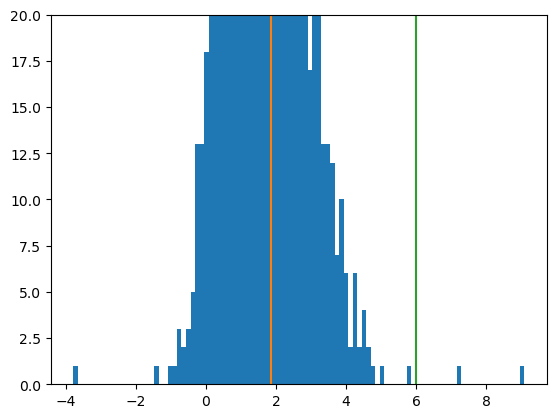

In [9]:
plt.hist(galaxy_sample["g-r"], bins = 100)
plt.plot([cutoff, cutoff], [0, 1000])
plt.plot([6,6],[0,1000])
plt.ylim(0,20)
plt.show()

In [10]:
cutoff

1.8549358649276804

In [11]:
questionables = SDSS.query_sql(""" 
SELECT TOP 9999 
s.plate,s.mjd,s.z,s.zErr,s.zWarning,s.class,p.dec,p.dered_g,p.dered_i,p.dered_r,p.dered_u,p.dered_z,p.objID,cast(str(p.ra,13,8) as float) as ra,
s.run1d, s.run2d, s.fiberID as fiberID, s.snMedian
FROM ..SpecObj as s 
JOIN ..PhotoObj AS p ON s.bestObjID = p.objID 
WHERE   (s.class = 'GALAXY') AND ( p.type = 3) AND p.dered_g-p.dered_r> 6 AND s.z > s.zErr AND s.snMedian > 1""")

In [12]:
len(questionables)

389

In [13]:
questionables[questionables["class"] != "GALAXY"]

plate,mjd,z,zErr,zWarning,class,dec,dered_g,dered_i,dered_r,dered_u,dered_z,objID,ra,run1d,run2d,fiberID,snMedian
int64,int64,float64,float64,int64,str6,float64,float64,float64,float64,float64,float64,uint64,float64,str7,str7,int64,float64


In [14]:
questionables["g-r"] = questionables["dered_g"] - questionables["dered_r"]

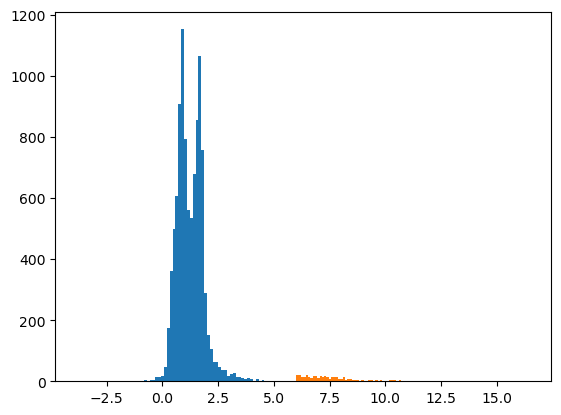

In [15]:
plt.hist(galaxy_sample["g-r"], bins = 100)
plt.hist(questionables["g-r"], bins = 100)
plt.show()

In [22]:
s = SDSS.get_spectra(matches = questionables)

In [99]:
def shape_of_spectra(wavelength,flux):
    #finds the shape of the spectra to later reshape spectra
    try:
        params,covariance = curve_fit(powlaw1, wavelength, flux)
        line = powlaw1(wavelength, *params)
        normalized_flux = flux/line
        return line,normalized_flux
    except RuntimeError:
        try: 
            params,covariance = curve_fit(law2, wavelength, flux)
            line = law2(wavelength, *params)
            normalized_flux = flux/line
            return line, normalized_flux
        except RuntimeError:
            return np.ones(len(wavelength))*np.nan,np.ones(len(wavelength))*np.nan

In [192]:
def spectra(data, table):
    sp = Table(names=('wavelength', 'flux','cont_flux', 'line', 'shifted'), dtype = (object, object, object, object, object))
    for i in range(len(data)):
        wavelength_og = (10**data[i][1].data["loglam"]) #take wavelength out of log
        wavelength = wavelength_og[wavelength_og<7500] #removing unreliably high wavelengths
        wavelength = wavelength/(1+table[i]["z"]) #going from observed to emitted
        flux_unedited = (data[i][1].data["flux"])[wavelength_og<7500] #removing corresponding flux
        l, flux_edited = shape_of_spectra(wavelength,flux_unedited) #finding shape of continuum
        sp.add_row((wavelength,flux_unedited,flux_edited, l, None))
    sp.add_column(table.columns["z"])
    sp.add_column(table.columns["snMedian"])
    return sp

In [193]:
s2 = spectra(s,questionables)

In [194]:
i = 300

In [195]:
halpha = 656.279*10
hbeta = 486.135*10
hgamma = 434.0472*10

0.26377597


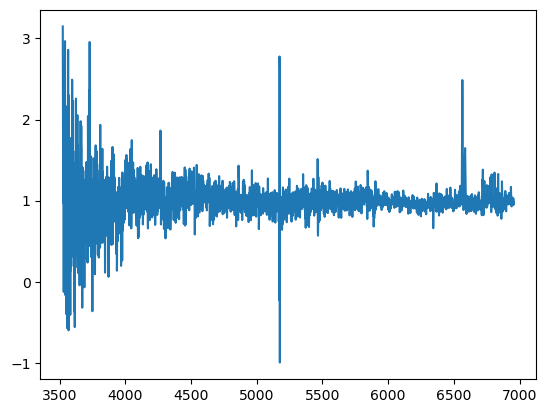

In [196]:
plt.plot(s2[i]["wavelength"], s2[i]["cont_flux"])
print(np.std(s2[i]["cont_flux"]))

In [197]:
possibles = list(range(len(s2)))
for i in range(len(s2)):
    avg = np.average(s2[i]["cont_flux"])
    std = 0.5*np.std(s2[i]["cont_flux"])
    if max(s2[i]["wavelength"])>halpha:
        halpha_value = s2[i]["cont_flux"][s2[i]["wavelength"]>halpha][-1]
        if halpha_value <= (avg+std) and halpha_value >= (avg-std):
            possibles.remove(i)
    if max(s2[i]["wavelength"])>hbeta:
        hbeta_value = s2[i]["cont_flux"][s2[i]["wavelength"]>hbeta][-1]
        if hbeta_value <= (avg+std) and hbeta_value >= (avg-std):
            if i in possibles:
                possibles.remove(i)  
    if max(s2[i]["wavelength"])>hgamma:
        hgamma_value = s2[i]["cont_flux"][s2[i]["wavelength"]>hgamma][-1]
        if hgamma_value <= (avg+std) and hgamma_value >= (avg-std):
            if i in possibles:
                possibles.remove(i)  

(0.0, 3.0)

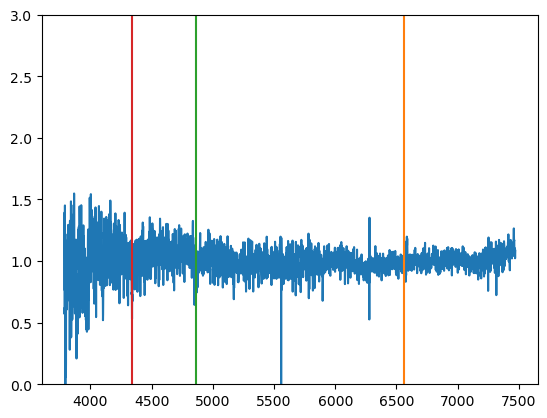

In [209]:
j = possibles[5]
plt.plot(s2[j]["wavelength"], s2[j]["cont_flux"])
plt.plot([halpha, halpha],[0,6])
plt.plot([hbeta, hbeta],[0,6])
plt.plot([hgamma, hgamma],[0,6])
plt.ylim(0,3)

In [219]:
ascii.write(questionables[possibles], 'questionables.csv', overwrite = True, format = "csv")